### Copying over some of the code used for calendar visualization to visualize some other locations/normalization methods

In [12]:
# Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

# Cleaning off first row and units
def clean_units(df):
    units_list = df.iloc[0]
    df = df.iloc[1:]

    # Cleaning units
    df = df.apply(pd.to_numeric)

    return df, units_list


In [13]:
# Importing NY Dataset
atx_df = pd.read_csv('BEopt Viz\\ny_undersized_timeseries.csv')
atx_df, units = clean_units(atx_df)
assert atx_df.shape[0] == 365*24 #asserting that each row is one hour our of the year

# Slicing out only wanted columns and labels and changing to datetime
full_labels_list = atx_df.columns.tolist()

living_space_columns = ['My Design - Temperature| Living Space', 'My Design - Temperature| Heating Setpoint', 'My Design - Temperature| Cooling Setpoint']
short_labels = ['living_space_temp', 'heating_setpoint', 'cooling_setpoint'] #temps in F
# Creating date range
date_range = pd.date_range(start="2023-01-01", end="2024-01-01", freq="1H", inclusive="left")

living_df = (atx_df[living_space_columns].set_axis(short_labels, axis=1) # slicing and renaming columns
                                         .set_index(date_range))         # changing to hourly index
            
assert living_df.shape[0] == 365*24
living_df.head()

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_25660\3775458202.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  atx_df = pd.read_csv('BEopt Viz\\ny_undersized_timeseries.csv')


,living_space_temp,heating_setpoint,cooling_setpoint
2023-01-01 00:00:00,73.00,73,76
2023-01-01 01:00:00,73.00,73,76
2023-01-01 02:00:00,73.00,73,76
2023-01-01 03:00:00,73.00,73,76
2023-01-01 04:00:00,72.79,73,76


In [14]:
# Adding columns: deviation over/under the heating/cooling setpoint

setpoint_diff = living_df['cooling_setpoint'] - living_df['heating_setpoint']
living_df['heating_deviation'] = living_df['living_space_temp'] - living_df['heating_setpoint']
living_df['cooling_deviation'] = living_df['living_space_temp'] - living_df['cooling_setpoint']

# True if the temperature is below the heating setpoint or above the cooling setpoint.
living_df['exceeds_setpoints'] = np.where((living_df['living_space_temp'] > living_df['cooling_setpoint']) | (living_df['living_space_temp']<living_df['heating_setpoint']), True, False)

# Slicing a dataframe with timepoints that exceed the temperature setpoints
#excess_df = living_df[living_df['exceeds_setpoints'] == True]

# Make new column for too hot, to cold, or in range
range_conditions = [living_df['living_space_temp'] < living_df['heating_setpoint'], living_df['living_space_temp'] > living_df['cooling_setpoint'], (living_df['living_space_temp'].between(living_df['heating_setpoint'], living_df['cooling_setpoint']))]
range_choices = ['Too Cold', 'Too Hot', 'In Range']
living_df['in_range'] = np.select(range_conditions, range_choices)

# Make new column for amount of excess degrees, 0 if within comfortable range.
excess_conditions = [living_df['in_range'] == 'Too Hot', living_df['in_range'] == 'Too Cold', living_df['in_range'] == 'In Range']
excess_choices = [living_df['cooling_deviation'], living_df['heating_deviation'], 0]
living_df['excess_temp'] = np.select(excess_conditions, excess_choices)

too_hot_df = living_df[living_df['in_range'] == 'Too Hot'] # If exceeds, cooling_deviation is magnitude
too_cold_df = living_df[living_df['in_range'] == 'Too Cold'] # If exceeds, heating_deviation is magnitude

living_df.head()

# Saving cleaned dataset
living_df.to_csv('ny_hourly_cleaned.csv')

In [15]:
import datetime as dt

# Condensing to day by day. Aggregating by excess minimum and maximum temperature.
living_dod_df = living_df.reset_index().rename(columns={'index': 'datetime'})
high_low_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).agg({'excess_temp': [np.min, np.max]})

high_low_df['excess_high_low'] = high_low_df['excess_temp']['amin'] + high_low_df['excess_temp']['amax'] #TODO: doesn't account for edge case day exceeds both heating and cooling

# Aggregating the rest of the dataframe by mean temperature for that day and adding column.
living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()
living_dod_df['excess_high_low'] = high_low_df['excess_high_low']
living_dod_df

excess_df = living_dod_df[living_dod_df['exceeds_setpoints'] != 0]

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_25660\1742728942.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()


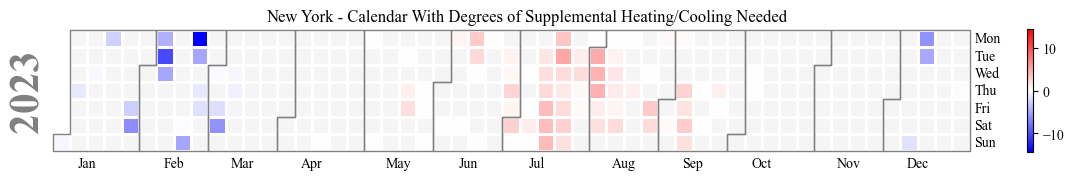

In [16]:
import calplot
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, CenteredNorm

# Creating custom color map to place white at 0 value.
cmap_min = excess_df['excess_high_low'].min()
cmap_max = excess_df['excess_high_low'].max()
ts_norm = TwoSlopeNorm(vmin = cmap_min, vcenter = 0, vmax = cmap_max)

excess_df.index = pd.to_datetime(excess_df.index)

# Plotting excess days on calendar heatmap, centered norm.
calplot.calplot(excess_df['excess_high_low'],suptitle = 'New York - Calendar With Degrees of Supplemental Heating/Cooling Needed',norm=CenteredNorm(),cmap = 'bwr')
plt.savefig('Viz_Outputs\\ny_cal_centered.pdf', bbox_inches='tight')

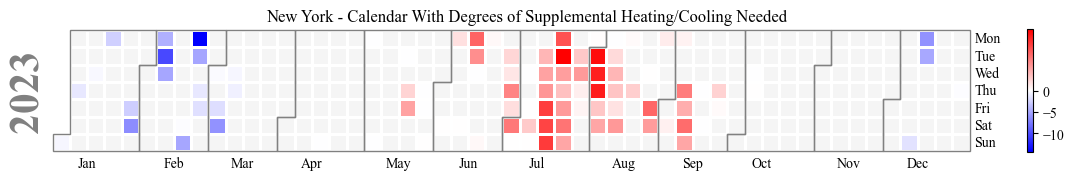

In [17]:
calplot.calplot(excess_df['excess_high_low'],suptitle = 'New York - Calendar With Degrees of Supplemental Heating/Cooling Needed',norm=ts_norm,cmap = 'bwr')
plt.savefig('Viz_Outputs\\ny_cal_tsnorm.pdf', bbox_inches='tight')